# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* <Nombre, Apellido>
* <Nombre, Apellido>
* <Nombre, Apellido>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sounddevice as sd
import pandas as pd
from scipy.fft import fft, ifft
from scipy.io import wavfile
from scipy import signal

from tkinter import Tk, filedialog
import shutil
from IPython.display import clear_output

import sys
sys.path.append('../')
from util.functions import plot, askBooleanInput, plotWAV, getWAVData, plotDataFrame

fs = 44100


## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

In [2]:

def save_files(files=[], visualize=False, save=False):                                    
    clear_output()
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    files.append(filedialog.askopenfilename(filetypes=[("wav files", "*.wav")]))
    anotherFile = askBooleanInput("Do you wish to add another file?")
    if anotherFile:
        save_files(files)
    
    if save:
        for file in files:
            shutil.copy(file, "media/save_files")

    if visualize:
        for file in files:
            plotWAV(file, title=file)
            
    return files


Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

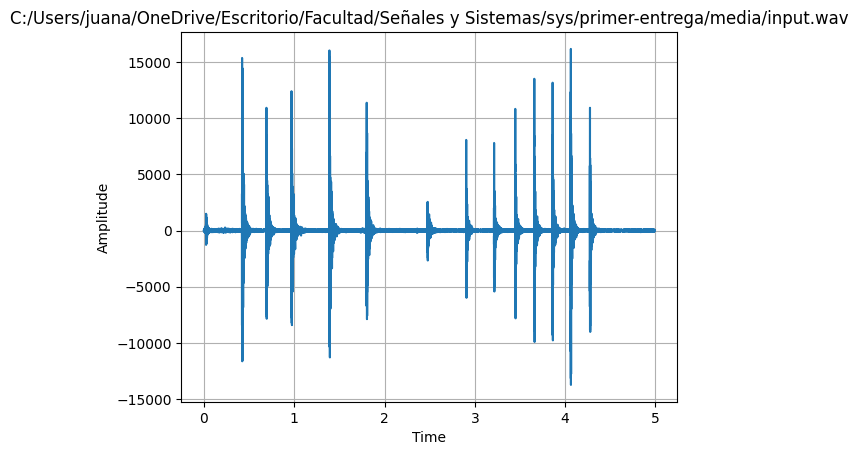

['C:/Users/juana/OneDrive/Escritorio/Facultad/Señales y Sistemas/sys/primer-entrega/media/input.wav']

In [4]:
save_files(files=[], visualize=True) # No use el botón porque se bugea con los inputs

## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{-\tau_it}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60_i}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
\tau_i=-\frac{ln(10^{-3})}{T_{60_i}}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60_i$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60_i$ conocidos que permita probar el software.

In [20]:
def synthesizeImpulseResponse(t60, duration = 3, band="octave", ai=1, fs=44100):
    centralFrequencies = [31.5,63,125,250,500,1000,2000,4000,8000,16000] if band == "octave" else [25,31.5,40,50,63,80,100,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000,10000,12500,16000,20000]
    t60 = np.array(t60)
    time = np.linspace(0, duration, duration*fs)
    impulseResponses = []
    for i in range(len(centralFrequencies)):
        tau = -np.log(10**(-3)) / t60[i]
        impulseResponses.append(ai*np.exp(-tau*time)*np.cos(2*np.pi*centralFrequencies[i]*time))

    impulseResponse = sum(impulseResponses)
    impulseResponse = impulseResponse / np.max(np.abs(impulseResponse)) # no se normaliza!! :(
    wavfile.write("media/synthesized-impulse-response.wav", fs, np.int16(impulseResponse * 32767))
    return impulseResponse, time
        


Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

In [21]:
# completar
t60 = [2.5, 2.4, 2.2, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0, 0.8]
impulseResponse, time = synthesizeImpulseResponse(t60)

Llamar la función de visualizar el dominio temporal, de la entrega anterior.

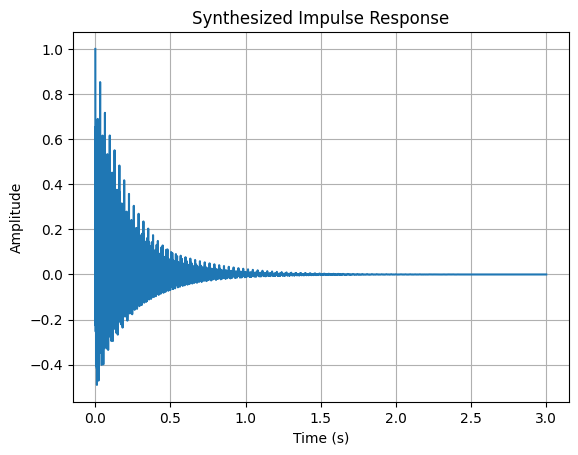

In [22]:
plot(time, impulseResponse, "Time (s)", "Amplitude", "Synthesized Impulse Response")

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

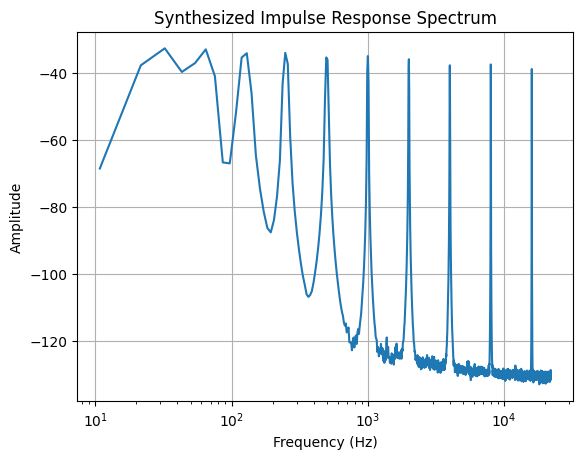

In [23]:
df = pd.read_csv("media/spectrum-synthesized-impulse-response.txt", sep='\t', header=0)
plot(df.iloc[:, 0], df.iloc[:, 1], "Frequency (Hz)", "Amplitude", "Synthesized Impulse Response Spectrum", "log")

Reproducir señal resultante.

In [41]:
sd.play(impulseResponse)
sd.wait()

Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

*completar*

## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

In [2]:
def getImpulseResponse(sineSweep, inverseFilter):
    sineSweepSpectrum = fft(sineSweep)
    inverseFilterSpectrum = fft(inverseFilter)

    impulseResponse = ifft(sineSweepSpectrum * inverseFilterSpectrum)
    impulseResponse = impulseResponse / np.max(np.abs(impulseResponse))
    
    impulseResponse = np.real(impulseResponse)

    return impulseResponse

Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

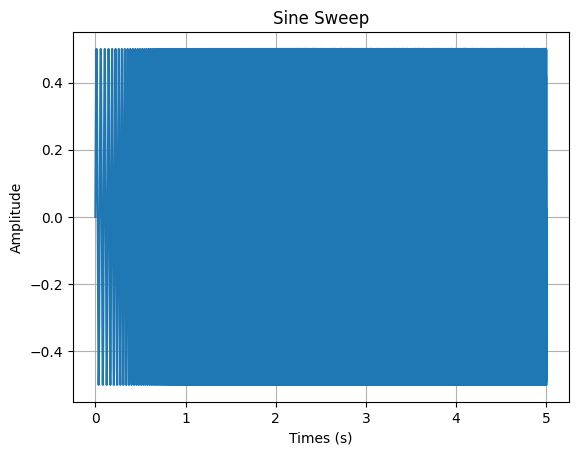

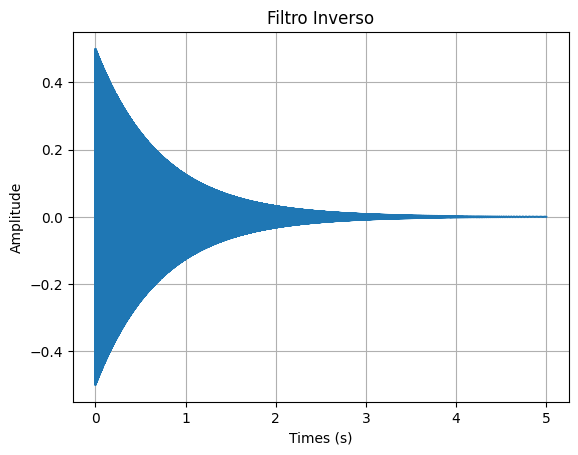

In [8]:
sineSweep, time = getWAVData("../primer-entrega/media/sine-sweep.wav")
inverseFilter, time = getWAVData("../primer-entrega/media/filtro-inverso.wav")

# WAV file normalization from int16 bit depth
sineSweep = (sineSweep / np.max(np.abs(sineSweep))) * 0.5
inverseFilter = inverseFilter / np.max(np.abs(inverseFilter)) * 0.5

plot(time, sineSweep, title="Sine Sweep")
plot(time, inverseFilter, title="Filtro Inverso")

impulseResponse = getImpulseResponse(sineSweep, inverseFilter)


Visualizar la señal con la función creada en la primer entrega.

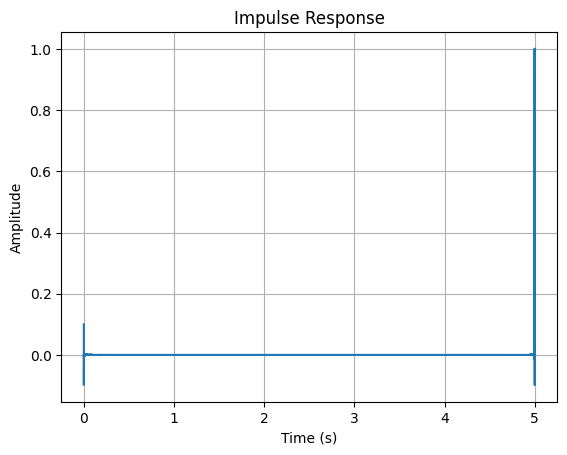

In [9]:
plot(time, impulseResponse, "Time (s)", "Amplitude", "Impulse Response")

Reproducir señal resultante.

In [42]:
sd.play(impulseResponse)

Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

*completar*

Mencionar aspectos que diferencian los impulso generados en esta función, con los sintetizados.

*completar*

## Función filtros norma IEC61260

**Consigna**: Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

> Para ver una introducción breve a la implementación de filtros, usar el siguiente [documento](https://github.com/maxiyommi/signal-systems/blob/master/material_extra/Filtros/intro_filtros.ipynb).

In [ ]:
#Octava - G = 1.0/2.0 / 1/3 de Octava - G=1.0/6.0
G = 1.0/2.0
factor = np.power(2, G)
centerFrequency_Hz = 1000

#Calculo los extremos de la banda a partir de la frecuencia central
lowerCutoffFrequency_Hz=centerFrequency_Hz/factor
upperCutoffFrequency_Hz=centerFrequency_Hz*factor

print('Frecuencia de corte inferior: ', round(lowerCutoffFrequency_Hz), 'Hz')
print('Frecuencia de corte superior: ', round(upperCutoffFrequency_Hz), 'Hz')

# Extraemos los coeficientes del filtro 
b,a = signal.iirfilter(4, [2*np.pi*lowerCutoffFrequency_Hz,2*np.pi*upperCutoffFrequency_Hz],
                            rs=60, btype='band', analog=True,
                            ftype='butter') 

# para aplicar el filtro es más óptimo
sos = signal.iirfilter(1, [lowerCutoffFrequency_Hz,upperCutoffFrequency_Hz],
                            rs=60, btype='band', analog=False,
                            ftype='butter', fs=fs, output='sos') 
w, h = signal.freqs(b,a)

# aplicando filtro al audio
filt = signal.sosfilt(sos, audiodata)

In [2]:
def filterSignalByBands(audioData, band = "octave"):
    signals = []
    centralFrequencies = [31.5,63,125,250,500,1000,2000,4000,8000,16000] if band == "octave" else [25,31.5,40,50,63,80,100,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000,10000,12500,16000,20000]

    for frequency in centralFrequencies:
        #Octava - G = 1.0/2.0 / 1/3 de Octava - G=1.0/6.0
        G = 1.0/2.0 if band == "octave" else 1.0/6.0
        factor = np.power(2, G)
        centerFrequency_Hz = frequency

        #Calculo los extremos de la banda a partir de la frecuencia central
        lowerCutoffFrequency_Hz = centerFrequency_Hz / factor
        upperCutoffFrequency_Hz = centerFrequency_Hz * factor

        print('Frecuencia de corte inferior: ', round(lowerCutoffFrequency_Hz), 'Hz')
        print('Frecuencia de corte superior: ', round(upperCutoffFrequency_Hz), 'Hz')

        # Extraemos los coeficientes del filtro 
        b,a = signal.iirfilter(4, [2*np.pi*lowerCutoffFrequency_Hz,2*np.pi*upperCutoffFrequency_Hz],
                                    rs=60, btype='band', analog=True,
                                    ftype='butter')

        # para aplicar el filtro es más óptimo
        sos = signal.iirfilter(4, [lowerCutoffFrequency_Hz,upperCutoffFrequency_Hz],
                                    rs=60, btype='band', analog=False,
                                    ftype='butter', fs=48000, output='sos') 
        w, h = signal.freqs(b,a)

        # aplicando filtro al audio
        signals.append(signal.sosfilt(sos, audioData))
    
    return signals

Llamar a la función con alguna RI generada anteriormente.

In [3]:
impulseResponse, time = getWAVData("media/synthesized-impulse-response.wav")
filteredImpulseResponseByOctaveList = filterSignalByBands(impulseResponse)

wavfile.write("media/filteredImpulseResponse500hz.wav", 44100, np.int16(filteredImpulseResponseByOctaveList[4] * 32767))

Frecuencia de corte inferior:  22 Hz
Frecuencia de corte superior:  45 Hz
Frecuencia de corte inferior:  45 Hz
Frecuencia de corte superior:  89 Hz
Frecuencia de corte inferior:  88 Hz
Frecuencia de corte superior:  177 Hz
Frecuencia de corte inferior:  177 Hz
Frecuencia de corte superior:  354 Hz
Frecuencia de corte inferior:  354 Hz
Frecuencia de corte superior:  707 Hz
Frecuencia de corte inferior:  707 Hz
Frecuencia de corte superior:  1414 Hz
Frecuencia de corte inferior:  1414 Hz
Frecuencia de corte superior:  2828 Hz
Frecuencia de corte inferior:  2828 Hz
Frecuencia de corte superior:  5657 Hz
Frecuencia de corte inferior:  5657 Hz
Frecuencia de corte superior:  11314 Hz
Frecuencia de corte inferior:  11314 Hz
Frecuencia de corte superior:  22627 Hz


Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

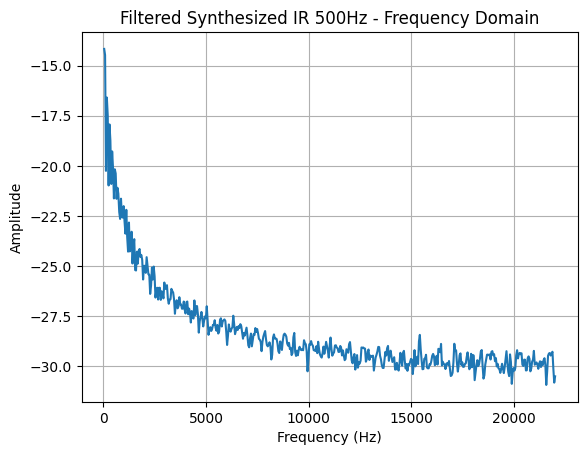

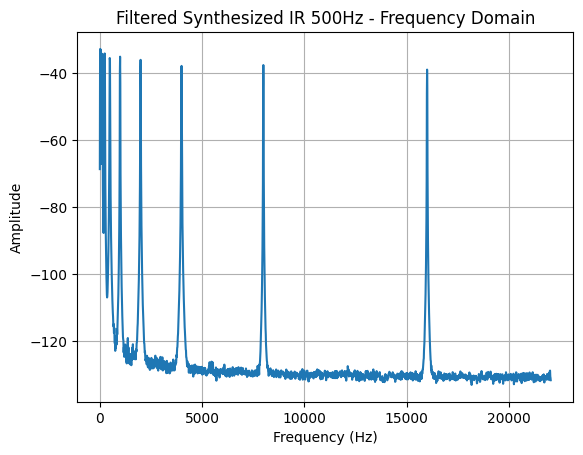

In [6]:
plotDataFrame("media/spectrum-filtered-synthesized-impulse-response500hz.txt", "Frequency (Hz)", "Amplitude", "Filtered Synthesized IR 500Hz - Frequency Domain")
plotDataFrame("media/spectrum-synthesized-impulse-response.txt", "Frequency (Hz)", "Amplitude", "Original Synthesized IR - Frequency Domain")


¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

*completar*

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [22]:
def logarithmicScaleConversion(signal):
    signal = np.where(signal == 0, 1e-10, signal)
    return 20 * np.log10(np.abs(signal/np.max(signal)))

Llamar a la función con alguna de las señales generadas anteriormente.

In [23]:
impulseResponse, time = getWAVData("media/synthesized-impulse-response.wav")

impulseResponseInLogScale = logarithmicScaleConversion(impulseResponse)

C:\Users\juana\AppData\Local\Temp\ipykernel_36380\2285063471.py:2: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(signal/np.max(signal))
C:\Users\juana\AppData\Local\Temp\ipykernel_36380\2285063471.py:2: RuntimeWarning: invalid value encountered in log10
  return 20 * np.log10(signal/np.max(signal))


Visualizar la señal con la función creada en la primer entrega.

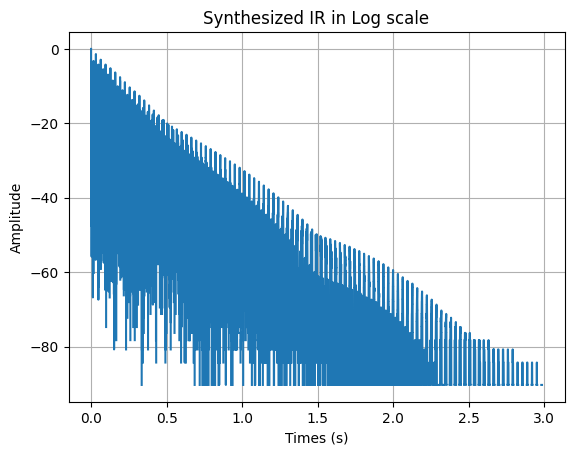

In [21]:
plot(time, impulseResponseInLogScale, title="Synthesized IR in Log scale") # Entiendo que no le pongo scale = log

### Informe preliminar (opcional)
Realizar un informe preliminar en formato UNTREF para memorias cuatrimestrales (disponible en el Drive de la asignatura), utilizando la plataforma de dición de documentos [LaTeX](https://es.wikipedia.org/wiki/LaTeX). Respetar las siguientes consignas:
1. Mencionar los detalles en el diseño de los scripts(con ayuda de diagramas de flujo o pseudocódigo) sin agregar código propiamente dicho.
2. Describir el dataset seleccionado para probar el software.
3. El informe debe reflejar la arquitectura del software desarrollado y los avances en la producción del mismo. Los datos que se informan tienen que ser relevantes y garantizar la reproducibilidad de los mismos. No ahondar en muchos detalles teóricos y definiciones(hacer uso de referencias),hacer más bien foco en la producción del software, su evaluación y su validación.
4. El informe preliminar no debe exceder las 3 páginas. Respetar fecha de entrega.
5. Respetar los siguientes porcentajes de contenido por sección(también determinan los grados de importancia)

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |

> Más información en el siguiente [link](https://github.com/maxiyommi/signal-systems/tree/master/trabajo_practico#informe-t%C3%A9cnico).